# Sentiment Analysis (Kaggle)

This challenge is a classification problem for text data that classify phrases (or sentense) on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

# Dataset

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

## 1. Data Preparation

Import necessary libraries and load the data using pandas

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.utils import to_categorical


In [159]:
train_movie_data = pd.read_csv('Rotten_Tomatoes_Dataset/train.tsv', sep = '\t')
test_movie_data = pd.read_csv('Rotten_Tomatoes_Dataset/test.tsv', sep = '\t')

## 1.1 Data Exploration

- Draw classes distribution: we can see that there are an imbalance between classes, most sentences are labeled with natural sentiment. Thus we will use matrics of f1-score, precision, recall instead of accuracy
- Draw the most frequent words in negative sentences and positive sentences. We can see that, there are many punctuation and common words which are not usefull in sentiment analysis. We will remove them in the data preprocessing step.
- We count the number of words in each sentence then draw the distribution of length of sentence.

In [160]:
train_movie_data.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [161]:
train_movie_data.dtypes

PhraseId       int64
SentenceId     int64
Phrase        object
Sentiment      int64
dtype: object

In [162]:
print(train_movie_data.shape, test_movie_data.shape)
train_movie_data.head(10)

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


### Classes Distribution

Text(0, 0.5, 'Number of reviews')

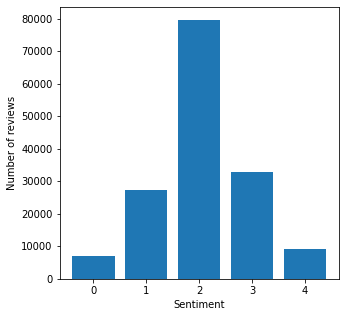

In [163]:
sentiment_count = train_movie_data['Sentiment'].value_counts()

plt.figure(figsize=(5,5))
plt.bar(sentiment_count.index, sentiment_count.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of reviews')


### Words Frequency

In [164]:
#  For negative sentence
def get_all_words(sentenses):
    for sentense in sentenses:
        for word in sentense.split():
            yield word

neg_sentenses = train_movie_data[train_movie_data['Sentiment'] == 0]['Phrase']
all_neg_words = get_all_words(neg_sentenses)

In [165]:
from nltk import FreqDist

freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_neg.most_common(20))

[(',', 3722), ('the', 3070), ('a', 2572), ('and', 2507), ('of', 2236), ('.', 1973), ('to', 1880), ('is', 1363), ("'s", 1136), ('that', 1130), ('in', 998), ('it', 927), ('movie', 757), ('as', 738), ('this', 576), ('for', 509), ('its', 488), ('film', 477), ('with', 437), ("n't", 424)]


In [166]:
#  For positive sentence

pos_sentenses = train_movie_data[train_movie_data['Sentiment'] == 4]['Phrase']
all_pos_words = get_all_words(pos_sentenses)

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(20))

[(',', 4879), ('and', 3968), ('the', 3819), ('a', 3311), ('of', 3022), ('.', 2280), ('is', 1547), ('to', 1540), ("'s", 1329), ('that', 1248), ('in', 1045), ('film', 930), ('with', 912), ('it', 739), ('as', 713), ('an', 664), ('movie', 564), ('for', 553), ('A', 520), ('its', 516)]


### Length of Sentences Distribution

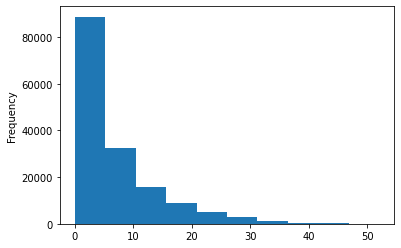

In [167]:
train_movie_data['LengthSentence'] = train_movie_data['Phrase'].apply(lambda x: len(x.split()))
train_movie_data['LengthSentence'].plot(kind = 'hist')

## 1.2 Data Pre-Processing

### Lower case
We need to lower case all words in sentences that to avoid having many copies of the same words.

In [168]:
train_movie_data['Phrase'] = train_movie_data['Phrase'].apply(lambda x: " ".join(w.lower() for w in x.split()))

### Removing Puntuation
Punctuations are useless in sentiment analysis, therefore we should remove them

In [169]:
train_movie_data['Phrase'] = train_movie_data['Phrase'].str.replace('[^\w\s]','')

### Removing Stop Words
Stop words are commonly occurring words that should be removed in this context because they are also useless in sentiment alanysis

In [170]:
from nltk.corpus import stopwords

SW = stopwords.words('english')
train_movie_data['Phrase'] = train_movie_data['Phrase'].apply(lambda x: " ".join(w for w in x.split() if w not in SW))

### Lemmatization
we dont want a word can be in different forms, for example (go, goes, went, gone). It can make the vocabulary and vectorizer bigger, but dont have any extra meaning in sentiment analysis.

Lemmatization is a method that converts the word into its root word.

In [171]:
from textblob import Word
train_movie_data['Phrase'] = train_movie_data['Phrase'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

### Words frequency
After counting the most frequent words in negative sentences and positive sentences, we can see that there are some words like "movie" and "film" occurred mostly but dont have any effect in sentiment analysis.

Therefore we should use Tfidf-vectorizer instead of CountVectorizer

In [172]:
neg_freq = pd.Series(' '.join(train_movie_data[train_movie_data['Sentiment'] == 0]['Phrase']).split()).value_counts()[:20]
neg_freq

movie        829
film         542
bad          434
nt           424
like         324
one          288
character    227
time         183
make         182
comedy       174
story        164
even         164
minute       161
would        146
worst        145
feel         139
plot         135
dull         134
rrb          131
way          131
dtype: int64

In [173]:
pos_freq = pd.Series(' '.join(train_movie_data[train_movie_data['Sentiment'] == 4]['Phrase']).split()).value_counts()[:20]
pos_freq

film            1091
movie            746
one              507
performance      472
best             370
funny            345
good             294
story            280
work             274
year             264
comedy           257
make             247
great            220
character        207
love             202
well             169
entertaining     168
fun              165
time             163
life             162
dtype: int64

### Train Test Splitting


In [174]:
y = train_movie_data['Sentiment']
X_train , X_val , y_train , y_val = train_test_split(train_movie_data['Phrase'],y,test_size = 0.20)

### Vectorize

In [175]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
vectorizer.fit(X_train)
train_vectorized = vectorizer.transform(X_train)
val_vectorized = vectorizer.transform(X_val)

# 2. Model Selection

## SVM

In [176]:
svm = LinearSVC()
svm.fit(train_vectorized,y_train)
print(classification_report( svm.predict(val_vectorized) , y_val))
print(accuracy_score( svm.predict(val_vectorized) , y_val ))

              precision    recall  f1-score   support

           0       0.40      0.49      0.44      1084
           1       0.50      0.57      0.53      4917
           2       0.81      0.73      0.77     17772
           3       0.52      0.57      0.55      5938
           4       0.43      0.54      0.48      1501

    accuracy                           0.66     31212
   macro avg       0.53      0.58      0.55     31212
weighted avg       0.68      0.66      0.66     31212

0.6550685633730616


## GRU

In [177]:
max_features = 13000
max_words = 50
batch_size = 128
epochs = 3
num_classes=5

In [178]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [179]:
X_train =pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)

In [180]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [181]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=['accuracy'])
model_GRU.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1300000   
_________________________________________________________________
gru_13 (GRU)                 (None, None, 64)          31680     
_________________________________________________________________
gru_14 (GRU)                 (None, 32)                9312      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 1,341,157
Trainable params: 1,341,157
Non-trainable params: 0
_________________________________________________________________


In [182]:
history_GRU=model_GRU.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),epochs=epochs, batch_size=batch_size, verbose=1)

/home/tuananh305/MALIS/Py3-Jupy/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 142s 1ms/step - loss: 1.0532 - accuracy: 0.5885 - val_loss: 0.8960 - val_accuracy: 0.6449
Epoch 2/3
124848/124848 [==============================] - 150s 1ms/step - loss: 0.8549 - accuracy: 0.6579 - val_loss: 0.8674 - val_accuracy: 0.6571
Epoch 3/3
124848/124848 [==============================] - 145s 1ms/step - loss: 0.7961 - accuracy: 0.6799 - val_loss: 0.8520 - val_accuracy: 0.6605


In [183]:
y_val_pred = model_GRU.predict_classes(X_val, verbose=1)
print(classification_report( y_val_pred , y_val))
print(accuracy_score( y_val_pred , y_val ))

31212/31212 [==============================] - 18s 587us/step
              precision    recall  f1-score   support

           0       0.29      0.55      0.38       706
           1       0.58      0.53      0.56      6020
           2       0.79      0.75      0.77     16604
           3       0.61      0.56      0.58      7152
           4       0.27      0.69      0.39       730

    accuracy                           0.66     31212
   macro avg       0.51      0.62      0.54     31212
weighted avg       0.68      0.66      0.67     31212

0.6605151864667436


In [184]:
model_LSTM=Sequential()
model_LSTM.add(Embedding(max_features,100,mask_zero=True))
model_LSTM.add(LSTM(64,dropout=0.4,return_sequences=True))
model_LSTM.add(LSTM(32,dropout=0.5,return_sequences=False))
model_LSTM.add(Dense(num_classes,activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         1300000   
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 165       
Total params: 1,354,821
Trainable params: 1,354,821
Non-trainable params: 0
_________________________________________________________________


In [185]:
history_LMST=model_LSTM.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),epochs=epochs, batch_size=batch_size, verbose=1)

/home/tuananh305/MALIS/Py3-Jupy/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 153s 1ms/step - loss: 1.0733 - accuracy: 0.5862 - val_loss: 0.9080 - val_accuracy: 0.6416
Epoch 2/3
124848/124848 [==============================] - 153s 1ms/step - loss: 0.8589 - accuracy: 0.6563 - val_loss: 0.8703 - val_accuracy: 0.6544
Epoch 3/3
124848/124848 [==============================] - 157s 1ms/step - loss: 0.8070 - accuracy: 0.6747 - val_loss: 0.8617 - val_accuracy: 0.6607


In [186]:
y_val_pred = model_LSTM.predict_classes(X_val, verbose=1)
print(classification_report( y_val_pred , y_val))
print(accuracy_score( y_val_pred , y_val ))

31212/31212 [==============================] - 19s 602us/step
              precision    recall  f1-score   support

           0       0.35      0.50      0.41       932
           1       0.51      0.55      0.53      5168
           2       0.83      0.73      0.78     18050
           3       0.55      0.58      0.57      6255
           4       0.28      0.65      0.39       807

    accuracy                           0.66     31212
   macro avg       0.50      0.60      0.54     31212
weighted avg       0.69      0.66      0.67     31212

0.6607074202229911
